In [1]:
import torch
import numpy as np
import torch_geometric
import yfinance as yf
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score, f1_score,
    accuracy_score, confusion_matrix, roc_auc_score, matthews_corrcoef
)
import pickle
import json
import concurrent.futures


In [2]:
def download_stock_data(symbols, interval='1d', start='1800-11-29', end='2024-2-12'):
    """
    下载给定时间范围内一组股票的股票数据。

    参数:
    - symbols (list): 股票符号列表。
    - interval (str): 股票行情数据的时间间隔 ('1d' 表示每日, '1h' 表示每小时, 等等)。
    - start (str): 数据的开始日期，格式为 'YYYY-MM-DD'。
    - end (str): 数据的结束日期，格式为 'YYYY-MM-DD'。

    返回:
    - dict: 一个字典，其中键是股票符号，值是相应的股票数据。
    """
    stock_data = {}

    for symbol in symbols:
        try:
            data = yf.download(symbol, interval=interval, start=start, end=end)
            stock_data[symbol] = data

        except Exception as e:
            print(f"下载 {symbol} 的数据失败: {e}")

    return stock_data

In [3]:
def process_stock_data(stock_data_result):
    """
    处理股票数据的函数

    Parameters:
    - stock_data_result (dict): 包含股票数据的字典，键为股票代码，值为对应的 Pandas DataFrame。

    Returns:
    - data_over (torch.Tensor): 处理后的股票数据，PyTorch 张量，已填充并添加均值列。
    - labels (torch.Tensor): 对应于相邻时间点的价格差异的标签，大于0的元素标记为1，其余为0。
    """

    # 创建一个空字典，用于存储 PyTorch 张量
    torch_stock_data = {}

    # 将 Pandas DataFrame 中的数据转换为 PyTorch 张量
    for stock_symbol, stock_data_df in stock_data_result.items():
        # 获取 DataFrame 中的所有列，并将其转换为 NumPy 数组
        stock_data_array = stock_data_df.values

        # 将 NumPy 数组转换为 PyTorch 张量
        stock_data_tensor = torch.tensor(stock_data_array, dtype=torch.float)

        # 将 PyTorch 张量存入新的字典
        torch_stock_data[stock_symbol] = stock_data_tensor

    # 找到每个张量的最大长度
    first_key = next(iter(torch_stock_data))
    Length = max(torch_stock_data[first_key].size(0), 1)  # 避免空字典引起错误

    # 使用 pad_sequence 进行填充
    padded_tensors = pad_sequence([torch.nn.functional.pad(t, (0, 0, 0, Length - t.size(0))) for t in torch_stock_data.values()])

    # 计算每列的均值
    column_means = torch.mean(padded_tensors, dim=1, keepdim=True)

    # 添加一行，该行的值是第二维度的均值
    padded_tensors_with_mean = torch.cat([padded_tensors, column_means.expand(-1, 1, -1)], dim=1)

    # 计算相邻时间点的差异
    differences = padded_tensors_with_mean[1:] - padded_tensors_with_mean[:-1]

    # 提取第一个维度的差异
    difference = differences[:, :, 0]

    # 将大于 0 的元素标记为 1
    labels = torch.zeros_like(difference, dtype=torch.long)
    labels[difference > 0] = 1

    # 去掉最后一行，得到处理后的数据
    data_over = padded_tensors_with_mean[:-1]

    return data_over, labels

In [4]:
def generate_adjacency_matrix(N):
    """
    生成有向图的邻接矩阵

    Parameters:
    - N (int): 股票数量，图的规模

    Returns:
    - adj_matrix (List[List[int]]): 生成的邻接矩阵
    """

    # 初始化邻接矩阵，全部初始化为 0
    adj_matrix = [[0] * (N + 1) for _ in range(N + 1)]

    
        

    # 1 到 N-1 的点全部指向 N 点
    for i in range(1, N):
        adj_matrix[i][N] = 1

    # N 点指向 0 点
    adj_matrix[N][0] = 1
    adj_matrix[0][0] = 1
    adj_matrix[N][N] = 1

    return adj_matrix

In [5]:
class CustomDataset(Dataset):
    def __init__(self, adj_matrix, data_over, labels, transform=None, pre_transform=None):
        """
        CustomDataset 构造函数。

        参数:
        - adj_matrix (List[List[int]]): 有向图的邻接矩阵。
        - data_over (List[List[float]]): 每个样本的特征向量列表。
        - labels (List[int]): 每个样本的标签列表。
        - transform (callable, 可选): 一个接受 PyTorch Geometric Data 对象并返回转换版本的函数/转换。默认为 None。
        - pre_transform (callable, 可选): 一个接受 PyTorch Geometric Data 对象并返回预转换版本的函数/转换。默认为 None。
        """
        # 将 adj_matrix 转换为 torch 张量
        adjacency_matrix = torch.tensor(adj_matrix)
        
        # 从 adjacency_matrix 创建 edge_index_what
        edge_index_form_adjacency_matrix = torch.nonzero(adjacency_matrix, as_tuple=True)
        edge_index_what = torch.stack([edge_index_form_adjacency_matrix[0], edge_index_form_adjacency_matrix[1]], dim=0)

        # 存储样本的特征
        self.data_over = data_over
        
        # 存储每个样本的边索引
        self.edge_index_what = edge_index_what
        
        # 存储每个样本的标签
        self.labels = labels
        
        # 调用父类的构造函数
        super(CustomDataset, self).__init__(None, transform, pre_transform)

    def len(self):
        """
        返回数据集中样本的数量。
        """
        return len(self.labels)

    def get(self, idx):
        """
        获取指定索引的 PyTorch Geometric Data 对象。

        参数:
        - idx (int): 样本的索引。

        返回:
        - data (Data): 包含特征、边索引和标签的 PyTorch Geometric Data 对象。
        """
        x = self.data_over[idx].clone().detach()
        edge_index = self.edge_index_what.clone().detach()
        y = self.labels[idx].clone().detach()






        
        # 创建 PyTorch Geometric Data 对象
        data = Data(x=x, edge_index=edge_index, y=y)
        return data

In [6]:
def SGFRELU(x):
    constant_term = torch.tensor(0.7524614220708874)
    coefficient1 = 0.5
    coefficient2 = 0.044715
    sqrt_coefficient = torch.sqrt(torch.tensor(2/3.14159265358979323846))
    bias_term = 0.17004075057125403

    result = (
        coefficient1 * (x - constant_term) * 
        (1 + torch.tanh(sqrt_coefficient * (x - constant_term + coefficient2 * (x - constant_term)**3)))
        + bias_term
    )

    return result

In [7]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y[0])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)





In [8]:
def test_one_epoch(model, loader):
    model.eval()
    all_predictions = []
    all_labels = []
    total_errors = 0
    total_samples = 0
    with torch.no_grad():
        for data in loader:
            out = model(data)
            _, predicted = torch.max(out, dim=0) 
            all_predictions.append(predicted.cpu().numpy().reshape(-1))
            all_labels.append(data.y[0].cpu().numpy().reshape(-1))
            total_samples += 1
            total_errors += (predicted != data.y[0]).item()
    predictions = np.concatenate(all_predictions)
    labels = np.concatenate(all_labels)
    error_rate = total_errors / total_samples
    return error_rate,predictions,labels


In [9]:
def create_data_loaders(dataset, batch_size=64, train_ratio=0.5, val_ratio=0.3, seed=1):
    """
    创建训练、验证和测试数据加载器。

    参数:
    - dataset (Dataset): 要划分的数据集。
    - batch_size (int, optional): 每个小批次的样本数。默认为 64。
    - train_ratio (float, optional): 训练集的比例。默认为 0.5。
    - val_ratio (float, optional): 验证集的比例。默认为 0.3。
    - seed (int, optional): 随机数生成器的种子。默认为 42。

    返回:
    - train_loader (DataLoader): 训练数据加载器。
    - val_loader (DataLoader): 验证数据加载器。
    - test_loader (DataLoader): 测试数据加载器。
    """
    num_data = len(dataset)
    num_train = int(train_ratio * num_data)
    num_val = int(val_ratio * num_data)
    num_test = num_data - num_train - num_val

    # 设置随机种子以保持可复现性
    generator = torch.Generator().manual_seed(seed)

    # 使用 random_split 划分数据集
    train_dataset, val_dataset, test_dataset = random_split(dataset, [num_train, num_val, num_test], generator=generator)

    # 构建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [10]:


class GraphAttentionNetwork(torch.nn.Module):
    def __init__(self, num_features, num_classes, hid_units=8, heads=8, num_layers=2, dropout=0.2):
        """
        GraphAttentionNetwork 类的构造函数。

        参数:
        - num_features (int): 图中每个节点的输入特征数。
        - num_classes (int): 分类的类别数。
        - hid_units (int, 可选): GAT 层中的隐藏单元数。默认为 8。
        - heads (int, 可选): GAT 层中的注意力头数。默认为 8。
        - num_layers (int, 可选): 网络中的 GAT 层数。默认为 2。
        - dropout (float, 可选): GAT 层的 dropout 概率。默认为 0.2。
        """
        super(GraphAttentionNetwork, self).__init__()

        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            in_units = num_features if layer == 0 else hid_units * heads
            out_units = num_classes if layer == num_layers - 1 else hid_units
            self.convs.append(GATConv(in_units, out_units, heads=heads, dropout=dropout))

        self.dropout = dropout  # 将 dropout 保存为属性

    def forward(self, data):
        """
        GraphAttentionNetwork 的前向传播。

        参数:
        - data (Data): 包含节点特征和边索引的 PyTorch Geometric Data 对象。

        返回:
        - log_probs (Tensor): 每个类别的对数概率。
        """
        x, edge_index = data.x, data.edge_index

        for conv in self.convs[:-1]:
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = SGFRELU(conv(x, edge_index))

        # 最后一层没有激活函数
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)

        return F.log_softmax(x[0], dim=0)

In [11]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs=20, **kwargs):
    train_errors = []
    val_errors = []
    train_losses = []

    for epoch in range(num_epochs):
        # Training
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        
        train_error,_,_ = test_one_epoch(model, train_loader)

        # Validation
        val_error,_,_ = test_one_epoch(model, val_loader)

        # Record visualization information
        train_errors.append(train_error)
        val_errors.append(val_error)
        train_losses.append(train_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Error: {train_error:.4f}, '
              f'Validation Error: {val_error:.4f}, Train Loss: {train_loss:.4f}')

    # Testing
    _,predictions ,labels  = test_one_epoch(model, test_loader)
    

    return predictions,labels,train_errors, val_errors, train_losses


In [12]:
# 示例：下载最知名的九个股票的数据
symbols_to_download = [ "^AORD", "^NZ50", "^JKSE", "^KLSE", "^HSI", "^TWII", "000001.SS", "399001.SZ", "^N225", "^STI", "^KS11", "^BSESN",  "^DJI", "^IXIC", "^NYA", "^XAX", "^RUT", "^VIX", "^GSPTSE", "^FTSE", "^GDAXI", "^FCHI", "^STOXX50E", "^N100", "^BFX", "IMOEX.ME", "^BVSP", "^MXX", "^MERV", "^TA125.TA", "^JN0U.JO", "^NSEI","^GSPC","^AXJO",]
stock_data_result = download_stock_data(symbols_to_download, interval='1d', start='1800-11-29', end='2024-2-12')

# 打印结果
N = len(stock_data_result)

for key, value in stock_data_result.items():
    num_values = len(value)
    print(f"键 '{key}' 的值数量: {num_values}")
    
data_over, labels = process_stock_data(stock_data_result)

adj_matrix = generate_adjacency_matrix(N)

# ... (previous code)

# Instantiate the CustomDataset class
dataset = CustomDataset(adj_matrix, data_over, labels)

with open('dataset.pkl', 'wb') as file:
    pickle.dump(stock_data_result, file)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [13]:


num_epochs = 5
hid_units = 32
num_layers = 2
heads = 16
batch_size =1
train_ratio = 0.35
val_ratio = 0.35


seed = 42
lr= 0.001
dropout = 0.1


train_loader, val_loader, test_loader = create_data_loaders(dataset, batch_size=batch_size, train_ratio=train_ratio, val_ratio=val_ratio, seed=seed)


model = GraphAttentionNetwork(num_features=dataset.num_node_features, num_classes=dataset.num_classes, hid_units=hid_units, heads=heads, num_layers=num_layers, dropout=dropout)



optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.NLLLoss()

predictions,labels,train_errors, val_errors, train_losses= train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs=num_epochs, hid_units=hid_units, heads=heads, num_layers=num_layers, dropout=dropout)




Epoch 1/5, Train Error: 0.4758, Validation Error: 0.4718, Train Loss: 16631166.3383
Epoch 2/5, Train Error: 0.5247, Validation Error: 0.5276, Train Loss: 569466.7881
Epoch 3/5, Train Error: 0.5102, Validation Error: 0.5162, Train Loss: 373717.6284
Epoch 4/5, Train Error: 0.4781, Validation Error: 0.4807, Train Loss: 2515.0880
Epoch 5/5, Train Error: 0.5073, Validation Error: 0.5082, Train Loss: 1074.8427


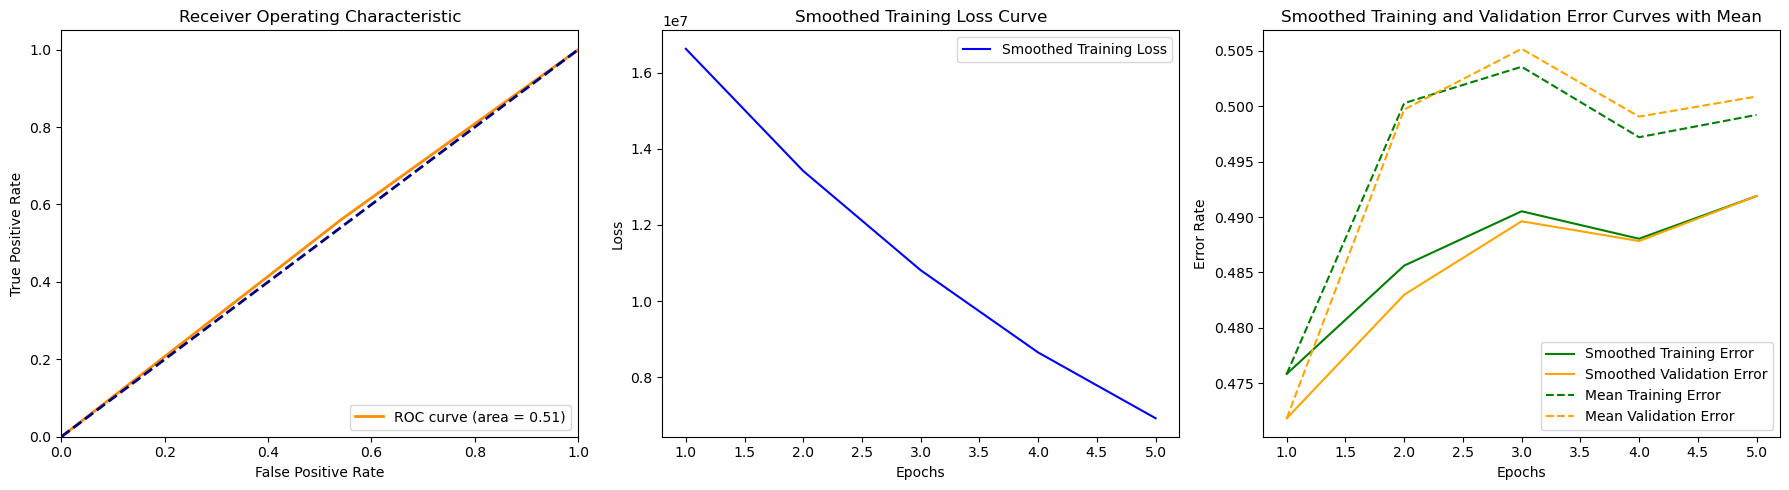


    | Metric        | Score         |
    |---------------|---------------|
    | Accuracy      | 0.5140 |
    | Precision     | 0.5492|
    | Recall        | 0.5617   |
    | F1 Score      | 0.5554      |
    | MCC           | 0.0197     |
    | ROC AUC       | 0.5098 |
    


In [14]:

# 计算指标
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)
conf_matrix = confusion_matrix(labels, predictions)
# ROC AUC 计算需要预测概率，您需要调整这部分以匹配您的模型输出
# 如果模型输出是概率，你可以使用类似这样的代码：
# probabilities = [prob[1] for prob in model_outputs]  # 假设二分类问题
# roc_auc = roc_auc_score(labels, probabilities)
mcc = matthews_corrcoef(labels, predictions)
fpr, tpr, thresholds = roc_curve(labels, predictions)

# 计算 AUC
roc_auc = auc(fpr, tpr)
# Function to smooth the curve for better visualization
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return np.array(smoothed_points)



# Smooth the training loss, training error, and validation error curves
smoothed_train_losses = smooth_curve(train_losses)
smoothed_train_errors = smooth_curve(train_errors)
smoothed_val_errors = smooth_curve(val_errors)

# Calculate the mean of training and validation errors for each epoch
mean_train_errors = [np.mean(train_errors[:i+1]) for i in range(num_epochs)]
mean_val_errors = [np.mean(val_errors[:i+1]) for i in range(num_epochs)]


# 创建子图
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# 绘制 ROC 曲线
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")
# 绘制平滑的训练损失曲线
axs[1].plot(range(1, num_epochs + 1), smoothed_train_losses, label='Smoothed Training Loss', color='blue')
axs[1].set_title('Smoothed Training Loss Curve')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

# 绘制平滑的训练和验证错误曲线以及平均线
axs[2].plot(range(1, num_epochs + 1), smoothed_train_errors, label='Smoothed Training Error', color='green')
axs[2].plot(range(1, num_epochs + 1), smoothed_val_errors, label='Smoothed Validation Error', color='orange')
axs[2].plot(range(1, num_epochs + 1), mean_train_errors, linestyle='--', color='green', label='Mean Training Error')
axs[2].plot(range(1, num_epochs + 1), mean_val_errors, linestyle='--', color='orange', label='Mean Validation Error')
axs[2].set_title('Smoothed Training and Validation Error Curves with Mean')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Error Rate')
axs[2].legend()
plt.tight_layout()
plt.show()
metrics_table = f"""
    | Metric        | Score         |
    |---------------|---------------|
    | Accuracy      | {accuracy:.4f} |
    | Precision     | {precision:.4f}|
    | Recall        | {recall:.4f}   |
    | F1 Score      | {f1:.4f}      |
    | MCC           | {mcc:.4f}     |
    | ROC AUC       | {roc_auc:.4f} |
    """
print(metrics_table)